# Chapter 3. Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)

plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5), facecolor='white')

## MNIST

Often considered the "Hello World" of ML, Scikit-Learn offers helper functions for downloading the MNIST 

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', data_home='assets/scikit_learn_data/')

In [3]:
mnist.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [5]:
mnist.target

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
X, y = mnist.data, mnist.target

Below is one of the data points shown as an image of its pixel intensities.

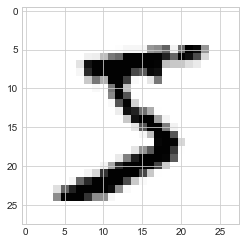

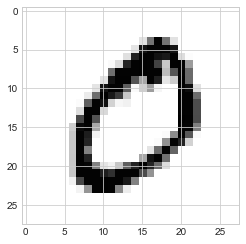

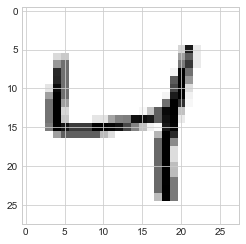

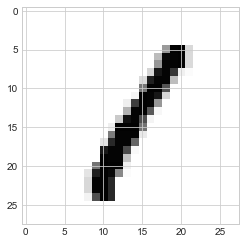

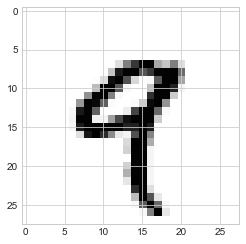

In [7]:
for i in range(5):
    first_digit = X[i]
    first_digit_image = first_digit.reshape(28, 28)
    plt.imshow(first_digit_image, interpolation=r'nearest')
    plt.show()

The MNIST data set is already split into training and testing sets at the 60,000 data point.

In [8]:
a = 60000
X_train, X_test, y_train, y_test = X[:a], X[a:], y[:a], y[a:]

We also want to shuffle the training data set to ensure there is no order to it.

In [9]:
idx = np.random.permutation(a)
X_train, y_train = X_train[idx], y_train[idx]

## Training a binary classifier

For a simpler example, we will try to create a binary classifier that can recognize 5's.

In [10]:
y_train_5 = y_train == '5'
y_test_5 = y_test == '5'

A simple type of classifier is the Stochastic Gradient Descent (SGD) classifer, the `SGDClassifier` class in Scikit-Learn.

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=0)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
# Try it on the first few training data points.
sgd_clf.predict(X[:5])

array([ True, False, False, False, False])

In [13]:
# Actual values.
y[:5]

array(['5', '0', '4', '1', '9'], dtype=object)

## Performance measures

First, we can see how well the model performs using cross-validation.

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9668 , 0.96315, 0.962  ])

While the accuracies seem high, all are above 90%, this might just happen because most values are not 5's.

In [15]:
1 - sum(y_train_5) / len(y_train_5)

0.90965

This shows that just guessing that the value is *not* 5 would result in an accuracy of 91%.
This is an example of why accuracy is often not the best descriptor of a classifier, especially on such a skewed data set.

### Confusion matrix

The confusion matrix shows the true and false positives and negatives.
The rows are the actual cases and the columns are predicted values.

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Get the predictions for each cross validation.
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Build the confusion matrix.
confusion_matrix(y_train_5, y_train_predict)

array([[53561,  1018],
       [ 1143,  4278]])

### Precision and recall

The **precision** is the ratio of true positives to all predicted positives.

$$
\frac{TP}{TP + FP}
$$

The **recall** is the ratio of true positives to the total number of real positives (the sum of true positives and false negatives).

$$
\frac{TP}{TP + FN}
$$

In [17]:
from sklearn.metrics import  precision_score, recall_score

# Measure the model's precision.
precision_score(y_train_5, y_train_predict)

0.8077794561933535

In [18]:
# Measure the model's accuracy.
recall_score(y_train_5, y_train_predict)

0.789153292750415

The precision and recall can be combined into the $\text{F}_{1}$ score.

$$
\text{F}_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}
= 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} \times \text{recall}}
= \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict)

0.7983577493701595

### Precision/recall tradeoff



Increasing precision reduces recall and vice versa.

The SGD classifier computes a *decision function* and then uses a threshold to decide to report positive or negative.
We can get these values directly by using the `decision_function()` method on the classifier object.

In [20]:
sgd_clf.decision_function([X_train[1]])

array([-11758.50171933])

We can get the values for all values by running the CV but asking for these decision function values.

In [21]:
y_scores = cross_val_predict(sgd_clf,
                             X_train,
                             y_train_5, 
                             cv=3, 
                             method='decision_function')
len(y_scores)

60000

We can create the precision-recall curve over various thresholds.

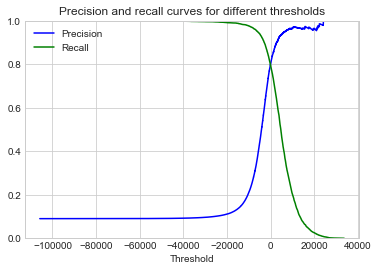

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b-', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.title('Precision and recall curves for different thresholds')
    plt.legend(loc='best'),
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

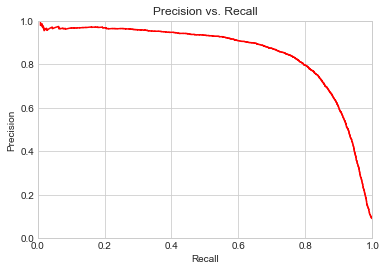

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'r-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1])
    plt.xlim([0, 1])

plot_precision_vs_recall(precisions, recalls)

### The ROC curve

The ROC curve plots the *true positive* rate over the *false positive* rate.
Ideally, the curve stays as far from the $y = x$ line as possible.
A measure of this is the *area under the curve*, AUC, of the ROC.
1 is a perfect score, where 0.5 means the model was no better than a random guess.

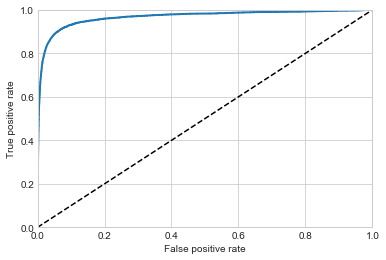

In [24]:
from sklearn.metrics import roc_curve


def plot_roc_curve(fpr, tpr, label=None):
    """Plot the ROC curve given the FPR and TPR for a model."""
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # black dotted line along y = x
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    
# Calculate and plot the FPR and TPC values.
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

In [25]:
from sklearn.metrics import  roc_auc_score

# Measure the AUC of the ROC.
roc_auc_score(y_train_5, y_scores)

0.9667389622712784

We now will train a random forest classifier to compare against the SGD.
There is no `decision_function()` method available for this model, instead, it provides the probabilities that each data point is part of each possible class.
This is found in the `predict_proba()` method.

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=0, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, 
                                    X_train, 
                                    y_train_5, 
                                    cv=3, 
                                    method='predict_proba')

The positive class's probability will be the score.

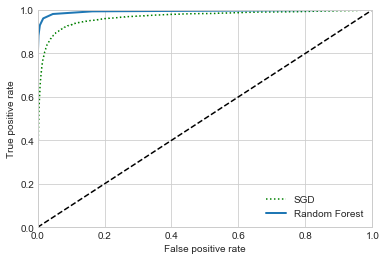

In [27]:
y_scores_forest  = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'g:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='best')
plt.show()

In [28]:
roc_auc_score(y_train_5, y_scores_forest)

0.993244900251192

## Multiclass classification

There are ways of using multiple binary classifiers for a multiclass classification.
*One-versus-all* (OvA) is where each classifier is trained to recognize just one class. When classifying a new input, the classifier with the highest score wins.
*One-versus-one* (OvO) is where each classifier is trained to discern between a pair of classes.
When classifying a new input, the class that wins the most duels wins overall.

Scikit-Learn automatically detects when a binary classifier is used with multiple classes and uses OvA for all except for SVM which uses OvO (for performance reasons).

In [29]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [30]:
some_digit = X_train[1]
sgd_clf.predict([some_digit])

array(['6'], dtype='<U1')

In [31]:
y_train[1]

'6'

Under the hood, Scikit-Learn trained 10 SGD classifiers, one for each digit, then compared their scores for the predictions.
We can see this directly by retrieving the decision function.

In [32]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-88731.40207822, -44288.57440539, -12195.31620434,
        -16414.83657055, -19614.87502217, -14826.23091153,
          2252.00046975, -52652.21976662, -15271.55559963,
        -18216.68320121]])

In [33]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

'6'

Here is an example of using a random forest for multiclass classification.

In [34]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['6'], dtype=object)

In [35]:
# Manually extract the class with the highest prediction.
forest_clf.classes_[np.argmax(forest_clf.predict_proba([some_digit]))]

'6'

These classifiers can be evaluated using CV, too.

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.88342332, 0.83469173, 0.87783167])

In [37]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.94026195, 0.94159708, 0.94244137])

### Error analysis